# 宏定义和库

In [1]:
%env OMP_NUM_THREADS=8 # 并行的线程数，可以被num_threads重写
%pylab inline
#自动重新加载更改的模块
%load_ext autoreload 
%autoreload 2

env: OMP_NUM_THREADS=8 # 并行的线程数，可以被num_threads重写
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys
import cv2
import math
import pickle
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from collections import namedtuple
import importlib
import inspect
import time
import glob
from imageio import imread, imsave
print('USE GPU #{} Host={}'.format(os.environ.get('CUDA_VISIBLE_DEVICES'), os.uname()[1]))
LOCAL_PATH = '../'
if LOCAL_PATH not in sys.path:
    sys.path.append(LOCAL_PATH)
from common.tf_layer_utils import *
from datasets import *
from det_tools import *
from inference import *
MODEL_PATH = '../models/'
if MODEL_PATH not in sys.path:
    sys.path.append(MODEL_PATH)
COMMON_PATH = '../common/'
if COMMON_PATH not in sys.path:
    sys.path.append(COMMON_PATH)
    
from io_utils import read_text
from jupyter_utils import display_image_batch

USE GPU #0 Host=multi-agent


In [3]:
# from eval_tools import draw_match, draw_keypoints
# MY_UTILS_PATH = '../../dnnutils/'
# if MY_UTILS_PATH not in sys.path:
#     sys.path.append(MY_UTILS_PATH)
# from book_plots import figsize
# from jupyter_utils import display_image_batch
# import tfvisualizer as tv
# from tfvisualizer import log_images, convert_tile_image

# from io_utils import load_pickle, read_text
# from book_format import load_style
# from det_tools import *
# from spatial_transformer import transformer_crop, inplane_inverse_warp, inplane_coordinate_warp
# load_style()

In [4]:
given_config = namedtuple('params', 'model')#第一个参数是名字，只是为了区分，实际上并不是一个参数
given_config.model = '../release/models/outdoor/'
given_config.top_k = 1024
yfcc_dir = '../release/outdoor_examples/'
given_config.img_dir = os.path.join(yfcc_dir, 'images')
given_config.dpt_dir = os.path.join(yfcc_dir, 'depths')
given_config.seq_names = ['sacre_coeur']
given_config.dist_thresh = 5

In [5]:
# load config file
# 加载文件夹中参数，跟前面的参数进行对比，不一样的重新进去
config_path = os.path.join(given_config.model, 'config.pkl')
try:
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
except:
    raise ValueError('Fail to open {}'.format(config_path))

# overwrite each given_config parameters
for attr, dst_val in sorted(vars(given_config).items()):
    if attr.startswith('_'):        
        continue
    elif hasattr(config, attr):
        src_val = getattr(config, attr)
        if src_val != dst_val:
            print('Overwrite {} : {} --> {}'.format(attr, src_val, dst_val))
            setattr(config, attr, dst_val)
    else:
        print('Add {} {}'.format(attr, dst_val))
        setattr(config, attr, dst_val)

Add dist_thresh 5
Add dpt_dir ../release/outdoor_examples/depths
Add img_dir ../release/outdoor_examples/images
Add model ../release/models/outdoor/
Add seq_names ['sacre_coeur']
Overwrite top_k : 512 --> 1024


In [6]:
config.net_num_scales

5

In [7]:
config.net_min_scale

0.7071067811865475

In [8]:
config.net_max_scale

1.4142135623730951

In [9]:
config.conv_ksize

5

In [10]:
config.batch_size

6

In [11]:
config.activ_fn

'leaky_relu'

In [12]:
tf.constant(False)

<tf.Tensor 'Const:0' shape=() dtype=bool>

In [13]:
tf.reset_default_graph()
batch_size = 1 # fixed
data_loader = RawSfMDataset(longer_edge=640)

dataset = data_loader.get_dataset(config.dpt_dir, config.img_dir, 
                config.seq_names, phase='valid', shuffle=True, seed=12345, max_examples=500)

next_batch = dataset.make_one_shot_iterator().get_next()
photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, theta_params, use_aug = next_batch
print(photos1.shape)
rgbs1 = tf.concat([photos1, photos1, photos1], axis=-1)
print(rgbs1.shape)
rgbs2 = tf.concat([photos2, photos2, photos2], axis=-1)
# Not apply any augmentations
thetas1 = tf.tile(tf.eye(3)[None], [batch_size, 1, 1])
thetas2 = tf.tile(tf.eye(3)[None], [batch_size, 1, 1])
inv_thetas1 = tf.matrix_inverse(thetas1)
inv_thetas2 = tf.matrix_inverse(thetas2)
# next_batch = [photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, 
#               c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, 
#               thetas1, thetas2, inv_thetas1, inv_thetas2, theta_params]

# photos1 = tf.placeholder(tf.float32, [None,None,None,1])
# photos2 = tf.placeholder(tf.float32, [None,None,None,1])
is_training = tf.placeholder(tf.bool)
print(is_training)

sacre_coeur has 4631 examples
---> actual size=500
aug_mode=none max_rad=0.0, max_scale_log=0.0
(?, ?, ?, 1)
(?, ?, ?, 3)
Tensor("Placeholder:0", dtype=bool)


# Detect and describe local features

In [14]:
config.detector

'mso_resnet_detector'

In [15]:
DET = importlib.import_module(config.detector)
detector = DET.Model(config, is_training)

if config.use_nms3d:
    print('Apply 3D NMS instead.')
    heatmaps1, det_endpoints = build_multi_scale_deep_detector_3DNMS(config, detector, photos1, reuse=False)
    heatmaps2, det_endpoints2 = build_multi_scale_deep_detector_3DNMS(config, detector, photos2, reuse=True)
else:
    heatmaps1, det_endpoints = build_multi_scale_deep_detector(config, detector, photos1, reuse=False)
    heatmaps2, det_endpoints2 = build_multi_scale_deep_detector(config, detector, photos2, reuse=True)
degree_maps1 = visualize_degree_map(det_endpoints['ori_maps'])
degree_maps2 = visualize_degree_map(det_endpoints2['ori_maps'])

Act-Fn:  <function get_activation_fn.<locals>.<lambda> at 0x7f8642eb8d90>
Apply 3D NMS instead.
Scales (0.707107~1.41 #5): [1.41421356 1.18920712 1.         0.84089642 0.70710678]
Instructions for updating:
dim is deprecated, use axis instead
INFO:tensorflow:Summary name ConvOnlyResNet/ori_conv/weights:0 is illegal; using ConvOnlyResNet/ori_conv/weights_0 instead.
INFO:tensorflow:Summary name ConvOnlyResNet/ori_conv/biases:0 is illegal; using ConvOnlyResNet/ori_conv/biases_0 instead.
PAD=16, #conv=8, ksize=5 ori-ksize=5
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
9
Scales (0.707107~1.41 #5): [1.41421356 1.18920712 1.         0.84089642 0.70710678]
PAD=16, #conv=8, ksize=5 ori-ksize=5
9


In [16]:
degree_maps1

<tf.Tensor 'degree_maps/GatherV2:0' shape=(?, ?, ?, 3) dtype=float32>

In [17]:
# extract patches
kpts1 = det_endpoints['kpts']
kpts2 = det_endpoints2['kpts']
batch_inds1 = det_endpoints['batch_inds']

kp_patches1 = build_patch_extraction(config, det_endpoints, photos1)
kp_patches2 = build_patch_extraction(config, det_endpoints2, photos2)

# Descriptor
DESC = importlib.import_module(config.descriptor)
descriptor = DESC.Model(config, is_training)
desc_feats1, desc_endpoints = descriptor.build_model(kp_patches1, reuse=False) # [B*K,D]
desc_feats2, _          = descriptor.build_model(kp_patches2, reuse=True) # [B*K,D]

32
32
Act-Fn:  <function relu at 0x7f86539170d0>
===== SimpleDesc (reuse=False) =====
#1 conv-bn-act (?, 16, 16, 64)
#2 conv-bn-act (?, 8, 8, 128)
#3 conv-bn-act (?, 4, 4, 256)
FLAT (?, 4096)
Feat-Norm: L2-NORM
FEAT (?, 256)
===== SimpleDesc (reuse=True) =====
#1 conv-bn-act (?, 16, 16, 64)
#2 conv-bn-act (?, 8, 8, 128)
#3 conv-bn-act (?, 4, 4, 256)
FLAT (?, 4096)
Feat-Norm: L2-NORM
FEAT (?, 256)


In [18]:
nn_dist, nn_inds2, _, _, _ = nearest_neighbors(desc_feats1, desc_feats2)
kpts2_corr = tf.cast(tf.gather(kpts2, nn_inds2), tf.float32)

In [19]:
print(nn_inds2)
print(kpts2_corr)

Tensor("ArgMin:0", shape=(?,), dtype=int64)
Tensor("GatherV2:0", shape=(?, 2), dtype=float32)


# Check with Ground truth

In [20]:
kpts1_int = tf.cast(kpts1, tf.int32)
heatmaps1w, visible_masks1, xy_maps1to2 = \
    inverse_warp_view_2_to_1(heatmaps2, depths2, depths1, c2Tc1s, 
                            K1=Ks1, K2=Ks2, 
                            inv_thetas1=inv_thetas1, thetas2=thetas2,
                            depth_thresh=config.depth_thresh)
heatmaps2w, visible_masks2, xy_maps2to1 = \
    inverse_warp_view_2_to_1(heatmaps1, depths1, depths2, c1Tc2s, 
                            K1=Ks2, K2=Ks1,
                            inv_thetas1=inv_thetas2, thetas2=thetas1,
                            depth_thresh=config.depth_thresh)
visible_masks1 = visible_masks1 * valid_masks1 # take 'and'
visible_masks2 = visible_masks2 * valid_masks2
print(valid_masks1)
print(valid_masks2)
kpts2w = batch_gather_keypoints(xy_maps1to2, batch_inds1, kpts1_int)
kpvis2w = batch_gather_keypoints(visible_masks1, batch_inds1, kpts1_int)[:,0] 
print(kpts2w)
print(kpvis2w)
match_dist = tf.maximum(tf.cast(tf.reduce_sum(tf.squared_difference(kpts2_corr, kpts2w), axis=1), tf.float32), 1e-6)
match_dist = tf.sqrt(match_dist)
is_match = tf.cast(tf.less_equal(match_dist, config.dist_thresh), tf.float32) * kpvis2w
print(is_match)

Tensor("IteratorGetNext:4", shape=(?, ?, ?, 1), dtype=float32)
Tensor("IteratorGetNext:5", shape=(?, ?, ?, 1), dtype=float32)
Tensor("GatherNd:0", shape=(?, 2), dtype=float32)
Tensor("strided_slice_6:0", shape=(?,), dtype=float32)
Tensor("mul_2:0", shape=(?,), dtype=float32)


In [21]:
# 动态申请显存
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth = True 
sess = tf.Session(config=tfconfig)
# 初始化模型参数
sess.run(tf.global_variables_initializer())

## Load model

In [22]:
# load model 实例化一个saver
saver = tf.train.Saver()
print('Load trained models...')

if os.path.isdir(config.model):
    checkpoint = tf.train.latest_checkpoint(config.model)
    model_dir = config.model
else:
    checkpoint = config.model
    model_dir = os.path.dirname(config.model)

if checkpoint is not None:
    print('Checkpoint', os.path.basename(checkpoint))
    print("[{}] Resuming...".format(time.asctime()))
    saver.restore(sess, checkpoint)
else:
    raise ValueError('Cannot load model from {}'.format(model_dir))    
print('Done.')

Load trained models...
Checkpoint models-latest-42000
[Sun Oct  7 23:12:45 2018] Resuming...
INFO:tensorflow:Restoring parameters from ../release/models/outdoor/models-latest-42000
Done.


In [23]:
feed_dict = {
    is_training: False,
}
fetch_dict = {
    'photos1': photos1,
    'photos2': photos2,
    'rgbs1': rgbs1,
    'rgbs2': rgbs2,
    'kpts1': kpts1,
    'kpts2': kpts2,
    'kpts2_corr': kpts2_corr,
    'is_match': is_match,
    'degree_maps1': degree_maps1,
    'degree_maps2': degree_maps2,
    'xy_maps1to2': xy_maps1to2,
    'visible_masks1': visible_masks1,
}
outs = sess.run(fetch_dict, feed_dict=feed_dict)

In [24]:
print(photos1)

Tensor("IteratorGetNext:0", shape=(?, ?, ?, 1), dtype=float32)


In [25]:
match_pair = np.concatenate([outs['kpts1'], outs['kpts2_corr']], axis=1)

match_pair = match_pair[outs['is_match']==1]

In [26]:
print(outs.keys())

dict_keys(['photos1', 'photos2', 'rgbs1', 'rgbs2', 'kpts1', 'kpts2', 'kpts2_corr', 'is_match', 'degree_maps1', 'degree_maps2', 'xy_maps1to2', 'visible_masks1'])


In [27]:
outs['photos1'][0]

array([[[0.05098039],
        [0.04752457],
        [0.05098039],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.06520221],
        [0.07073889],
        [0.07294574],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.07848039],
        [0.0892565 ],
        [0.09516336],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)

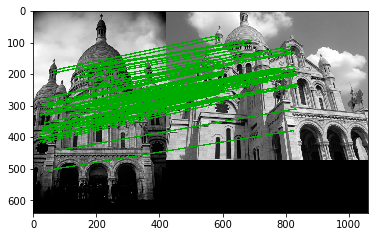

In [28]:
rgb1 = outs['rgbs1'][0]
rgb2 = outs['rgbs2'][0]
match_pairs = np.concatenate([outs['kpts1'], outs['kpts2_corr']], axis=1)
match_pairs = match_pairs[outs['is_match']==1]

h1, w1 = rgb1.shape[:2]
h2, w2 = rgb2.shape[:2]
canvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)
canvas[:h1, :w1] = rgb1
canvas[:h2, w1:] = rgb2
fig = plt.figure(frameon=False)# #去掉图例边框 
fig = plt.imshow(canvas)
xs = match_pairs[:,[0,2]]

xs[:,1] += w1
ys = match_pairs[:,[1,3]]

lw = .25
alpha = 1
sf = 5
lw = .2
markersize = 1

plt.plot(
    xs.T, ys.T,
    alpha=alpha,
    linestyle="-",
    linewidth=lw,
    aa=False,
    marker='.',
    markersize=markersize,
    color=[0.0, 0.67, 0.0],
);


In [29]:
print(xs.shape)
print(ys.shape)
print('#Matches = {}'.format(len(match_pairs)))

(64, 2)
(64, 2)
#Matches = 64


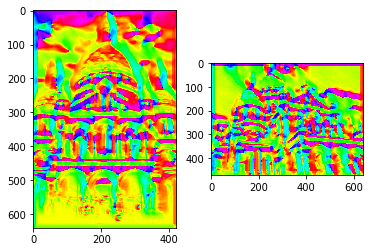

In [30]:
plt.subplot(121)
plt.imshow(outs['degree_maps1'][0])
plt.subplot(122)
plt.imshow(outs['degree_maps2'][0])

## SIFT

In [31]:
# SIFT
sift_endpoints = build_competitor_matching_estimation(config, dist_thresh=config.dist_thresh)

In [32]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=config.top_k, contrastThreshold=1e-5)
sift_in1 = (rgb1[...,0]*255).astype(np.uint8)
sift_in2 = (rgb2[...,0]*255).astype(np.uint8)
kp1, des1 = sift.detectAndCompute(sift_in1,None)
kp2, des2 = sift.detectAndCompute(sift_in2,None)
print(kp1)
kp1 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp1])
kp2 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp2])
print(kp1)
print('#SIFT keypoints = {}, {}'.format(len(kp1), len(kp2)))

[<KeyPoint 0x7f861c047f30>, <KeyPoint 0x7f8642f0a720>, <KeyPoint 0x7f862925f3f0>, <KeyPoint 0x7f862925f450>, <KeyPoint 0x7f8640919390>, <KeyPoint 0x7f861c16a600>, <KeyPoint 0x7f86147c9630>, <KeyPoint 0x7f86147c9930>, <KeyPoint 0x7f86147c9960>, <KeyPoint 0x7f86147c9990>, <KeyPoint 0x7f86147c98a0>, <KeyPoint 0x7f86147c97b0>, <KeyPoint 0x7f86147c9840>, <KeyPoint 0x7f86147c9a20>, <KeyPoint 0x7f86147c9a50>, <KeyPoint 0x7f86147c9a80>, <KeyPoint 0x7f86147c9ab0>, <KeyPoint 0x7f86147c9ae0>, <KeyPoint 0x7f86147c9b10>, <KeyPoint 0x7f86147c9b40>, <KeyPoint 0x7f86147c9b70>, <KeyPoint 0x7f86147c9ba0>, <KeyPoint 0x7f86147c9bd0>, <KeyPoint 0x7f86147c9c00>, <KeyPoint 0x7f86147c9c30>, <KeyPoint 0x7f86147c9c60>, <KeyPoint 0x7f86147c9c90>, <KeyPoint 0x7f86147c9cc0>, <KeyPoint 0x7f86147c9cf0>, <KeyPoint 0x7f86147c9d20>, <KeyPoint 0x7f86147c9d50>, <KeyPoint 0x7f86147c9d80>, <KeyPoint 0x7f86147c9db0>, <KeyPoint 0x7f86147c9de0>, <KeyPoint 0x7f86147c9e10>, <KeyPoint 0x7f86147c9e40>, <KeyPoint 0x7f86147c9e70>, 

In [33]:
feed_dict = {
    sift_endpoints['feats1_ph']: des1,
    sift_endpoints['feats2_ph']: des2,
    sift_endpoints['kpts1_ph']: kp1,
    sift_endpoints['kpts2_ph']: kp2,
    sift_endpoints['xy_maps1to2_ph']: outs['xy_maps1to2'],
    sift_endpoints['visible_masks1_ph']: outs['visible_masks1']
}
fetch_dict = {
    'kpts2_corr': sift_endpoints['kpts2_corr'],
    'is_match': sift_endpoints['is_match'],
}
outs = sess.run(fetch_dict, feed_dict)

#Matches = 20


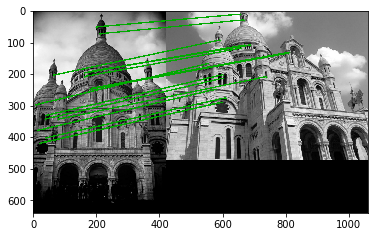

In [34]:
match_pairs = np.concatenate([kp1, outs['kpts2_corr']], axis=1)
match_pairs = match_pairs[outs['is_match']==1]

h1, w1 = rgb1.shape[:2]
h2, w2 = rgb2.shape[:2]
canvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)
canvas[:h1, :w1] = rgb1
canvas[:h2, w1:] = rgb2
fig = plt.figure(frameon=False)
fig = plt.imshow(canvas)

xs = match_pairs[:,[0,2]]
xs[:,1] += w1
ys = match_pairs[:,[1,3]]

lw = .25
alpha = 1
sf = 5
lw = .2
markersize = 1

plt.plot(
    xs.T, ys.T,
    alpha=alpha,
    linestyle="-",
    linewidth=lw,
    aa=False,
    marker='.',
    markersize=markersize,
    color=[0.0, 0.67, 0.0],
);
print('#Matches = {}'.format(len(match_pairs)))